### Build a simple MLP VAE model for MNIST and freyface
**作者**: `蒋羽`
**日期**: `2025-09-20`

**参考项目**：https://github.com/pytorch/examples/tree/main/vae

**目标**: 快速实现并对比两种VAE模型。
- **MNIST**: 二元似然 (BCE Loss)。
- **Frey Face**: 高斯似然 (MSE Loss)。
- **可视化**: 随机采样10个样本，展示 `原始图 (X)`, `重建图 (X')`, `残差 (|X-X'|)`.

#### 1. 导入库

In [ ]:
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

#### 2. 环境与参数设置

In [ ]:
# --- 参数配置 ---
CONFIG = {
    "batch_size": 128, "epochs_mnist": 10, "epochs_frey": 250,
    "lr": 1e-3, "seed": 1,
}

# --- 环境设置 ---
torch.manual_seed(CONFIG["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs('results_mnist', exist_ok=True)
os.makedirs('results_freyface', exist_ok=True)

#### 3. 模型与损失函数定义

In [ ]:
# --- VAE 模型定义 ---
class VAE_Binary(nn.Module): # For MNIST
    def __init__(self, z_dim=20):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 400), nn.ReLU())
        self.fc_mu, self.fc_logvar = nn.Linear(400, z_dim), nn.Linear(400, z_dim)
        self.decoder = nn.Sequential(nn.Linear(z_dim, 400), nn.ReLU(), nn.Linear(400, 784), nn.Sigmoid())

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x.view(-1, 784))
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

class VAE_Gaussian(nn.Module): # For Frey Face
    def __init__(self, z_dim=30):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(560, 200), nn.ReLU())
        self.fc_mu, self.fc_logvar = nn.Linear(200, z_dim), nn.Linear(200, z_dim)
        self.decoder = nn.Sequential(nn.Linear(z_dim, 200), nn.ReLU(), nn.Linear(200, 560))

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x.view(-1, 560))
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# --- 损失函数定义 ---
def loss_function_bce(recon_x, x, mu, logvar, beta=1.0):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

def loss_function_mse(recon_x, x, mu, logvar, beta=1.0):
    MSE = F.mse_loss(recon_x, x.view(-1, 560), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD

#### 4. MNIST 数据加载与训练

In [ ]:
# --- 数据加载 ---
mnist_train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=CONFIG['batch_size'], shuffle=True)
mnist_test_loader = DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=CONFIG['batch_size'], shuffle=True) # Shuffle for random sampling

# --- 模型训练 ---
model_mnist = VAE_Binary().to(device)
optimizer_mnist = optim.Adam(model_mnist.parameters(), lr=CONFIG['lr'])
print("--- Training VAE on MNIST ---")
for epoch in range(1, CONFIG['epochs_mnist'] + 1):
    model_mnist.train()
    for data, _ in mnist_train_loader:
        data = data.to(device)
        optimizer_mnist.zero_grad()
        recon_batch, mu, logvar = model_mnist(data)
        loss = loss_function_bce(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer_mnist.step()
    print(f'Epoch: {epoch}, Loss: {loss.item() / len(data):.4f}')

#### 5. Frey Face 数据加载与训练

In [ ]:
# --- 数据加载 ---
frey_faces = loadmat("frey_rawface.mat")["ff"].T.astype('float32') / 255.0
frey_dataset = TensorDataset(torch.from_numpy(frey_faces))
frey_loader = DataLoader(frey_dataset, batch_size=CONFIG['batch_size'], shuffle=True)

# --- 模型训练 ---
model_frey = VAE_Gaussian().to(device)
optimizer_frey = optim.Adam(model_frey.parameters(), lr=CONFIG['lr'])
print("\n--- Training VAE on Frey Face ---")
for epoch in range(1, CONFIG['epochs_frey'] + 1):
    model_frey.train()
    for data, in frey_loader:
        data = data.to(device)
        optimizer_frey.zero_grad()
        recon_batch, mu, logvar = model_frey(data)
        loss = loss_function_mse(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer_frey.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item() / len(data):.4f}')

#### 6. 可视化

In [ ]:
# MNIST 结果可视化
data_batch, _ = next(iter(mnist_test_loader))
indices = torch.randperm(data_batch.size(0))[:10]
samples_X = data_batch[indices].to(device)
recon_X, _, _ = model_mnist(samples_X)
recon_X_reshaped = recon_X.view(10, 1, 28, 28)
residual = torch.abs(samples_X - recon_X_reshaped)
comparison = torch.cat([samples_X,
                        recon_X_reshaped,
                        residual])
save_image(comparison.cpu(),
            'results_mnist/results_mnist.png',
            nrow=10)
print("Saved MNIST originals, reconstructions, and residuals to 'results_mnist/results_mnist.png'")

# Frey Face 结果可视化
data_batch, = next(iter(frey_loader))
indices = torch.randperm(data_batch.size(0))[:10]
samples_X = data_batch[indices].to(device)
recon_X, _, _ = model_frey(samples_X)
img_shape = (28, 20)
recon_X_reshaped = recon_X.view(10, 1, *img_shape)
residual = torch.abs(samples_X.view(10, 1, *img_shape) - recon_X_reshaped)
comparison = torch.cat([samples_X.view(10, 1, *img_shape),
                        recon_X_reshaped,
                        residual])
save_image(comparison.cpu(),
            'results_freyface/results_freyface.png',
            nrow=10)
print("Saved Frey Face originals, reconstructions, and residuals to 'results_freyface/results_freyface.png'")

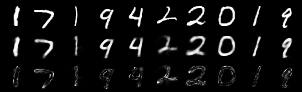
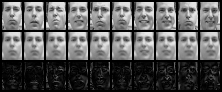